In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from pathlib import Path 
import pandas as pd 
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

DATA_DIR = Path("../../data")
JOKES_DIR = DATA_DIR / "jokes"
BERT_EMBEDDINGS = DATA_DIR / "bert_embeddings"
FASTTEXT_EMBEDDINGS = DATA_DIR / "fasttext_embeddings"

In [3]:
NAN = 99

In [4]:
ratings_path = DATA_DIR / 'jester-data-1.xls'
xl = pd.ExcelFile(ratings_path)
print(xl.sheet_names)
ratings = xl.parse(xl.sheet_names[0], header=None)
ratings = ratings.loc[:, 1:]

['jester-data-1-new']


## Analiza Danych

Oceny żartów są z przedziału [-10, 10], jednak w danych występuje też wartość 99, która oznacza brak oceny. Pierwsza kolumna oznacza ilość wystawionych przez użytkownika ocen, jednak ta informacja zdaje się zbędna w kontekście problemu, bo nie chcemy uczyć modelu konkretnie dla tego zbioru żartów, tak więc ta kolumna zostanie usunięta.

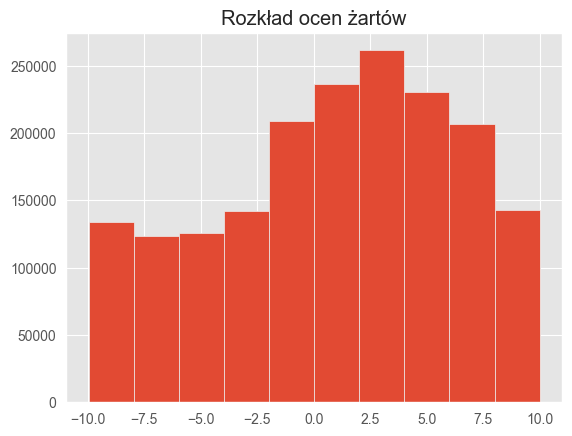

In [5]:
plt.title('Rozkład ocen żartów')
_ = plt.hist(ratings[ratings < NAN].values.flatten())

Około 28% ocen to wartości puste

In [6]:
np.round(np.sum(np.sum(ratings >= NAN)) / ratings.size, 2)

0.28

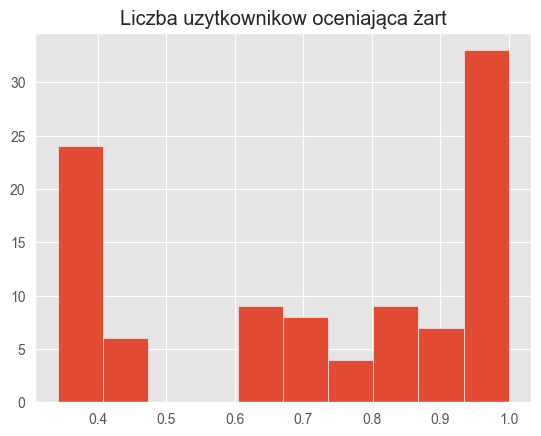

In [7]:
users_ratio_per_jokes_ratings = np.sum(ratings < NAN) / ratings.shape[0]
plt.title('Liczba uzytkownikow oceniająca żart')
_ = plt.hist(users_ratio_per_jokes_ratings)

In [8]:
user_group_ratings = pd.cut(users_ratio_per_jokes_ratings, bins=5, labels=['< 20%', '20 - 40%', '40 - 60%', '60 - 80%', '80 - 100%'])

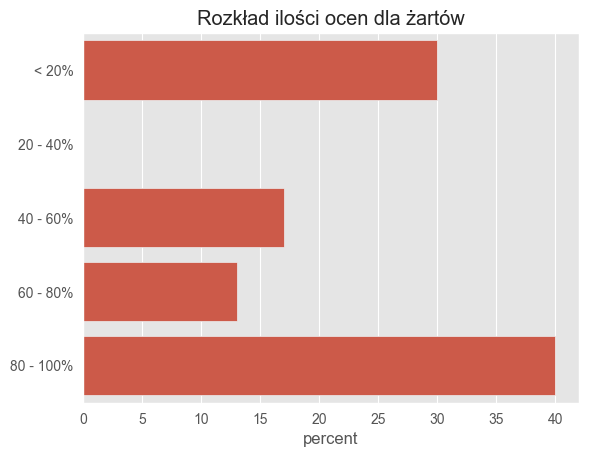

In [9]:
plt.title('Rozkład ilości ocen dla żartów')
_ = sns.countplot(user_group_ratings, stat='percent')

Ważne jest to, by podczas obliczania średniej oceny nie brać pod uwagę ocen o wartości 99

In [10]:
ratings_description = ratings[ratings < NAN].describe().transpose()
ratings_description['% user'] = users_ratio_per_jokes_ratings
ratings_description['% user cat'] = user_group_ratings

In [11]:
ratings_description = ratings_description.reset_index().rename({'index': 'joke_id'}, axis=1).set_index(np.arange(1, 101))

In [12]:
ratings_description.head()

,joke_id,count,mean,std,min,25%,50%,75%,max,% user,% user cat
1,1,16452.0,0.904573,5.171798,-9.95,-2.67,1.60,4.90,9.37,0.658528,40 - 60%
2,2,18184.0,0.208460,5.597327,-9.95,-4.42,0.83,4.82,9.37,0.727855,40 - 60%
3,3,16642.0,0.316574,5.399806,-9.95,-4.03,0.78,4.66,9.37,0.666133,40 - 60%
4,4,15608.0,-1.449114,5.234654,-9.95,-5.87,-1.46,2.52,9.37,0.624745,40 - 60%
5,5,24977.0,0.403556,5.255700,-9.95,-3.69,1.12,4.47,9.37,0.999760,80 - 100%


Obserwacje: 
- średnie oceny wahają się w przedziale [-4, 4]
- odchylenia standardowe są dosyć duże (w kontekście zakresu ocen) - w przedziale [4, 6]
- ocena i średnia zdają się być trochę większe dla żartów mniej ocenianych
- minimalna ocena jest praktycznie taka sama dla wszystkich żartów
- maksymalna ma trochę bardziej różnorodny rozkład, chociaż mocno stronniczy

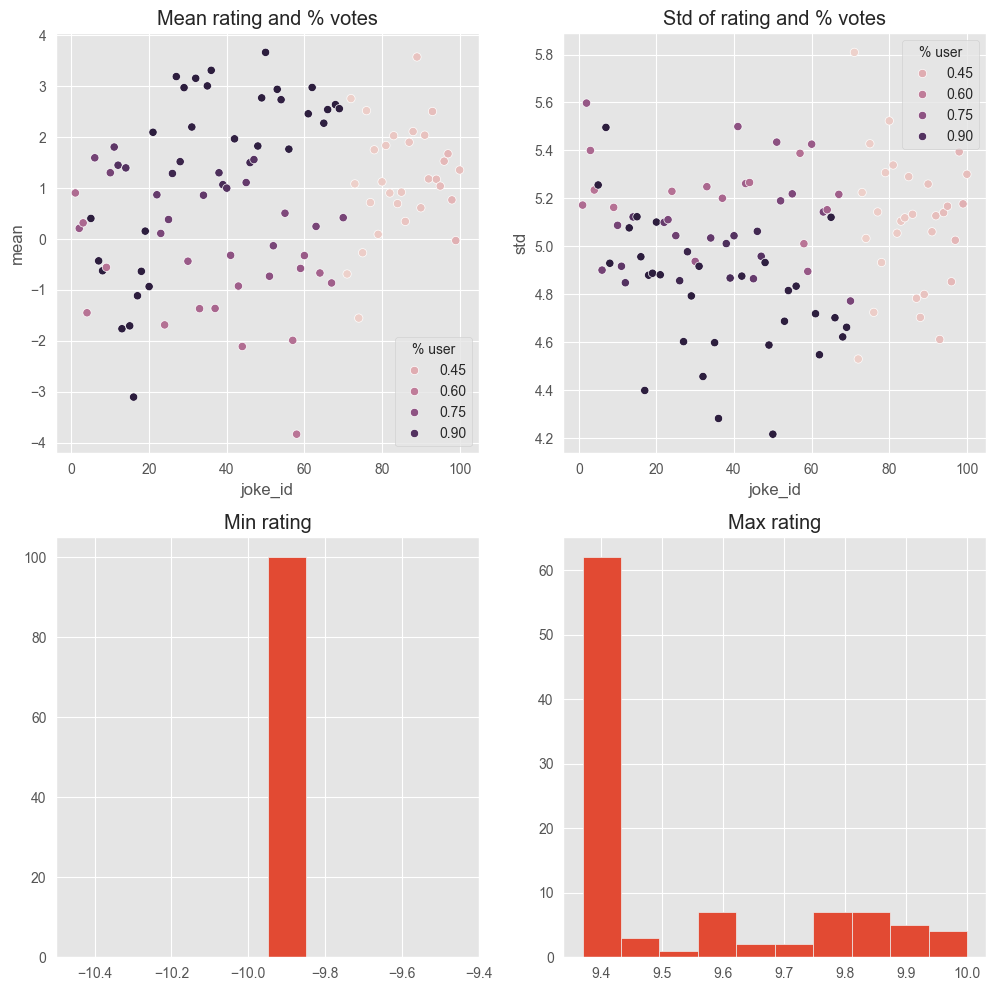

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1, title='Mean rating and % votes')
sns.scatterplot(ratings_description, x='joke_id', y='mean', hue='% user')
plt.subplot(2, 2, 2, title='Std of rating and % votes')
sns.scatterplot(ratings_description, x='joke_id', y='std', hue='% user')
plt.subplot(2, 2, 3, title='Min rating')
plt.hist(ratings_description['min'])
plt.subplot(2, 2, 4, title='Max rating')
_ = plt.hist(ratings_description['max'])

In [14]:
ratings_description['mean - median'] = ratings_description['mean'] - ratings_description['50%']

W przypadku mediany możemy zauważyć, że podobnie rozkłada się ona w przedziale [-4, 4], natomiast różnica między średnią a medianą jest w większości poniżej 0. 

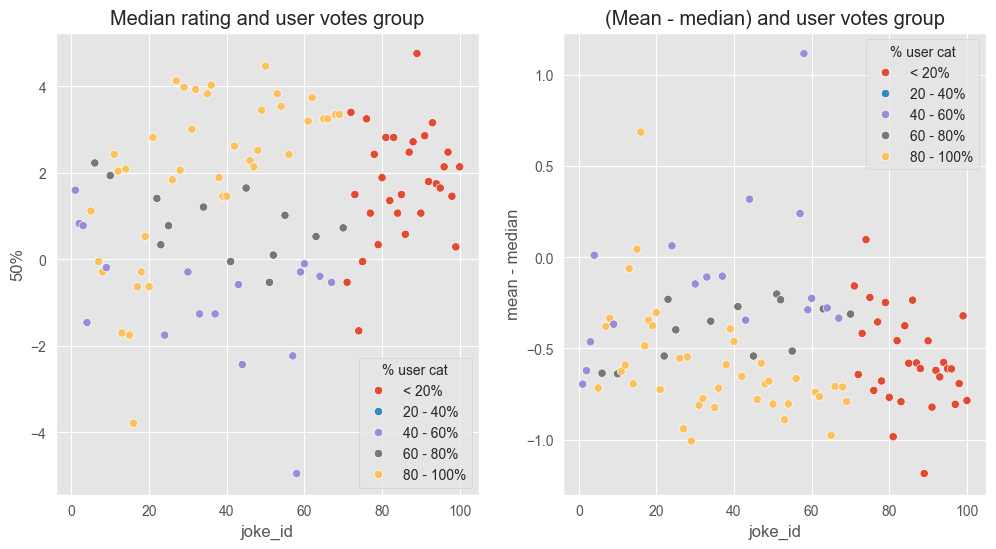

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1, title='Median rating and user votes group')
sns.scatterplot(ratings_description, x='joke_id', y='50%', hue='% user cat')
plt.subplot(1, 2, 2, title='(Mean - median) and user votes group')
_ = sns.scatterplot(ratings_description, x='joke_id', y='mean - median', hue='% user cat')

(array([32.,  7.,  1.,  0.,  2.,  2.,  0.,  0.,  0., 14.]),
 array([-9.66 , -7.951, -6.242, -4.533, -2.824, -1.115,  0.594,  2.303,
         4.012,  5.721,  7.43 ]),
 <BarContainer object of 10 artists>)

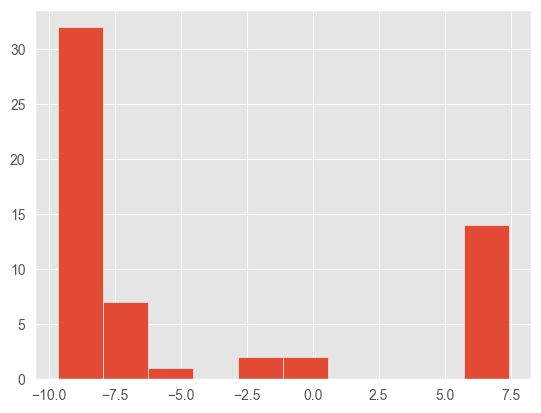

In [16]:
plt.hist(ratings.loc[58, ratings[58] < NAN])

<Axes: >

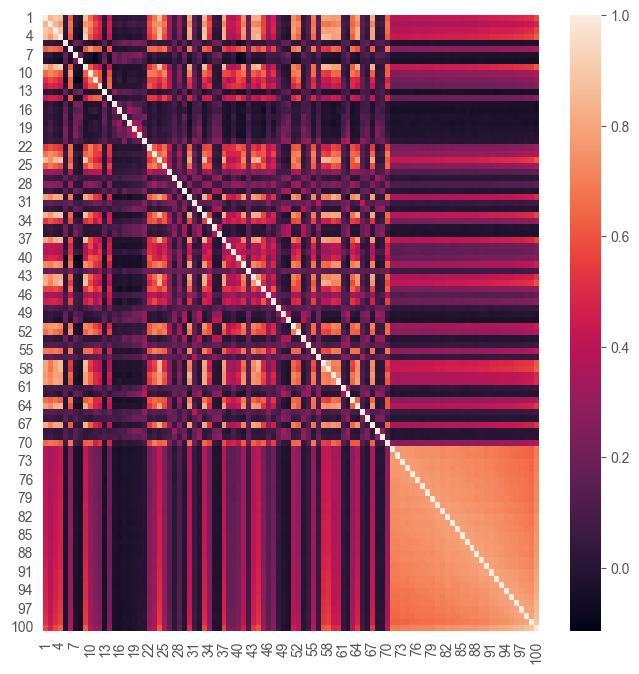

In [17]:
correlation_matrix = ratings.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=False)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
latent_matrix = svd.fit_transform(ratings)

Macierz podobieństwa kosinusowego wg. ocen żartów przez użytkowników - podobieństwa między ocenami różnych żartów dla tych samych użytkowników

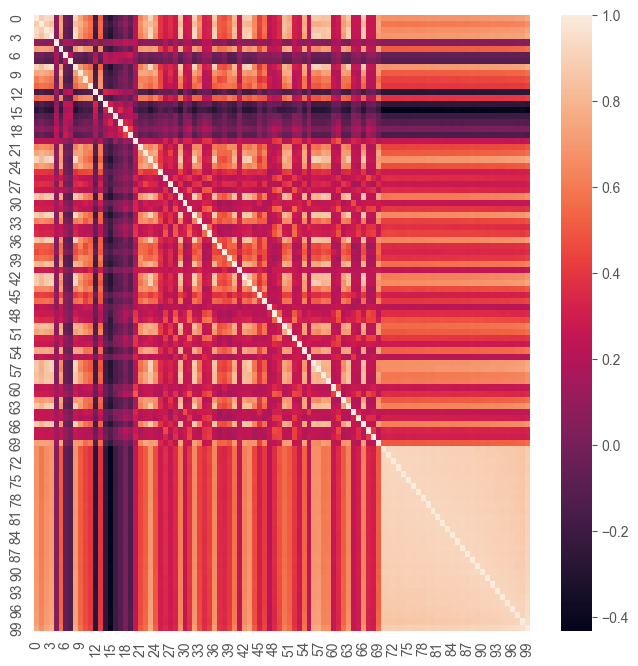

In [19]:
joke_similarity = cosine_similarity(ratings.T)
plt.figure(figsize=(8, 8))
sns.heatmap(joke_similarity, annot=False)
plt.show()

### Preprocessing danych
Na wejściu do sieci najlepiej będzie podać znormalizowane dane z usunięciem wartości pustych, czyli tych bez oceny.
Dane będą w postaci długiej, gdzie każdy wiersz będzie odpowiadał ocenie jednego żartu przez jednego użytkownika

In [20]:
# normalized_ratings = ratings[ratings < NAN]

In [21]:
normalized_ratings = (ratings[ratings < NAN] - ratings_description['min']) / (ratings_description['max'] - ratings_description['min'])

In [22]:
# normalized_ratings = (ratings[ratings < NAN] - ratings_description['mean']) / ratings_description['std']

In [23]:
normalized_ratings

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.110248,0.969979,0.015010,0.092650,0.125776,0.074665,0.005112,0.716388,0.048866,0.268634,...,0.654536,NaN,NaN,NaN,NaN,NaN,0.223602,NaN,NaN,NaN
1,0.726190,0.500000,0.844203,0.741201,0.391822,0.014933,0.471370,0.233891,0.948615,0.992236,...,0.654536,0.258131,0.500000,0.919463,0.505176,0.404244,0.673395,0.532609,0.291408,0.570393
2,NaN,NaN,NaN,NaN,0.982402,0.989701,0.970348,0.975140,NaN,NaN,...,NaN,NaN,NaN,0.982447,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.947205,NaN,NaN,0.608178,0.932544,0.364519,0.819888,NaN,0.610248,...,NaN,NaN,NaN,0.541043,NaN,NaN,NaN,NaN,NaN,NaN
4,0.954969,0.753623,0.299172,0.236025,0.585404,0.594748,0.868609,0.738711,0.479093,0.811594,...,0.776012,0.801755,0.736025,0.781621,0.811594,0.595238,0.675983,0.854037,0.608178,0.597826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.537785,0.899586,0.984990,0.635611,0.680642,0.859938,0.059305,0.477930,0.060957,0.889234,...,0.962583,0.451213,0.992236,0.167785,0.952381,0.982402,0.854037,0.964803,0.969979,0.899586
24979,0.987578,0.092650,0.959627,0.984990,0.560041,0.052523,0.329755,0.798072,0.092695,0.768634,...,0.450026,0.217863,0.439441,0.526071,0.992236,0.090580,0.140787,0.070393,0.987578,0.952381
24980,NaN,NaN,NaN,NaN,0.112836,NaN,0.851227,0.162354,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,0.012422,NaN,0.741820,0.083714,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
preprocessed_ratings = normalized_ratings.melt(ignore_index=False).reset_index().rename(columns={'variable': 'joke_id', 'value': 'rating', 'index': 'user_id'}).dropna()

In [25]:
preprocessed_ratings[preprocessed_ratings['user_id'] == 1]

,user_id,joke_id,rating
1,1,1,0.726190
24984,1,2,0.500000
49967,1,3,0.844203
74950,1,4,0.741201
99933,1,5,0.391822
...,...,...,...
2373386,1,96,0.404244
2398369,1,97,0.673395
2423352,1,98,0.532609
2448335,1,99,0.291408


In [26]:
preprocessed_ratings.shape

(1810455, 3)

In [27]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_test = train_test_split(preprocessed_ratings, stratify=preprocessed_ratings['joke_id'])
ratings_train, _ = train_test_split(ratings_train, stratify=ratings_train['joke_id'], test_size=0.5)

In [28]:
ratings_train.shape

(678920, 3)

In [29]:
def create_dataset(embeddings, ratings):
    # X are embeddings 
    # y are ratings 
    X = pd.DataFrame(embeddings.astype(np.float32))
    embeddings_cols = X.columns
    merged = pd.merge(ratings, X, left_on='joke_id', right_index=True)
    X = merged[embeddings_cols]
    y = merged['rating']
    return X, y

## Podstawowy model & fasttext

In [30]:
ft_embeds = np.zeros((101, 300))

for f in os.listdir(FASTTEXT_EMBEDDINGS):
    joke_num = int(f.split(".")[0][4:])
    ft_embeds[joke_num] = np.load(FASTTEXT_EMBEDDINGS / f)
    
ft_embeds[1:] = ft_embeds[1:] / ft_embeds[1:].sum(axis=1, keepdims=1)
X_train_ft, y_train_ft = create_dataset(ft_embeds, ratings_train)
X_test_ft, y_test_ft = create_dataset(ft_embeds, ratings_test)
print(X_train_ft.shape)

(678920, 300)


In [ ]:
mlp_base_ft = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', verbose=True)
mlp_base_ft.fit(X_train_ft, y_train_ft)

## Podstawowy model & bert

In [31]:
bt_embeds = np.zeros((101, 768))

for f in os.listdir(BERT_EMBEDDINGS):
    joke_num = int(f.split(".")[0][4:])
    bt_embeds[joke_num] = np.load(BERT_EMBEDDINGS / f)
    
bt_embeds[1:] = bt_embeds[1:] / bt_embeds[1:].sum(axis=1, keepdims=1)
X_train_bt, y_train_bt = create_dataset(bt_embeds, ratings_train)
X_test_bt, y_test_bt = create_dataset(bt_embeds, ratings_test)
print(X_train_bt.shape)

(678920, 768)


In [ ]:
mlp_base_bt = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', verbose=True)
mlp_base_bt.fit(X_train_bt, y_train_bt)

### Porównanie podstawowych modeli 

**Krzywa uczenia**

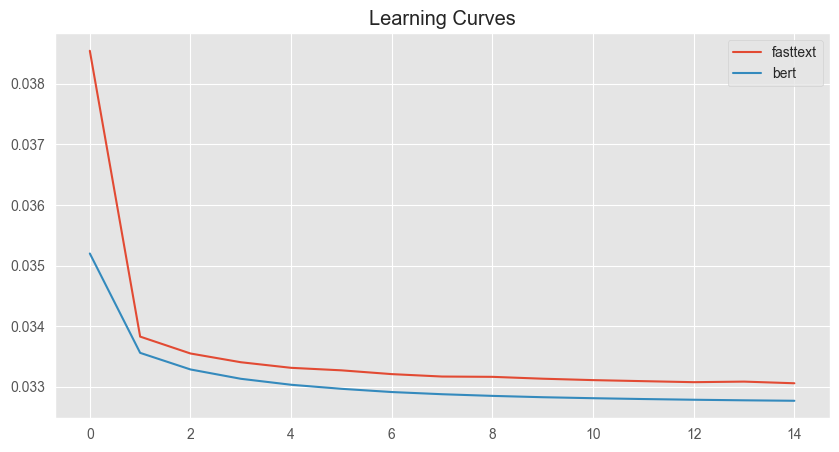

In [34]:
plt.figure(figsize=(10, 5))
plt.title('Learning Curves')
plt.plot(np.arange(len(mlp_base_ft.loss_curve_)), mlp_base_ft.loss_curve_, label='fasttext')
plt.plot(np.arange(len(mlp_base_bt.loss_curve_)), mlp_base_bt.loss_curve_, label='bert')
_ = plt.legend()

Różnice nie są istotne między dwoma modelami, jednak widać, że przy modelu fasttext krzywa uczenia jest systematycznie ponad krzywą dla modelu BERT. 

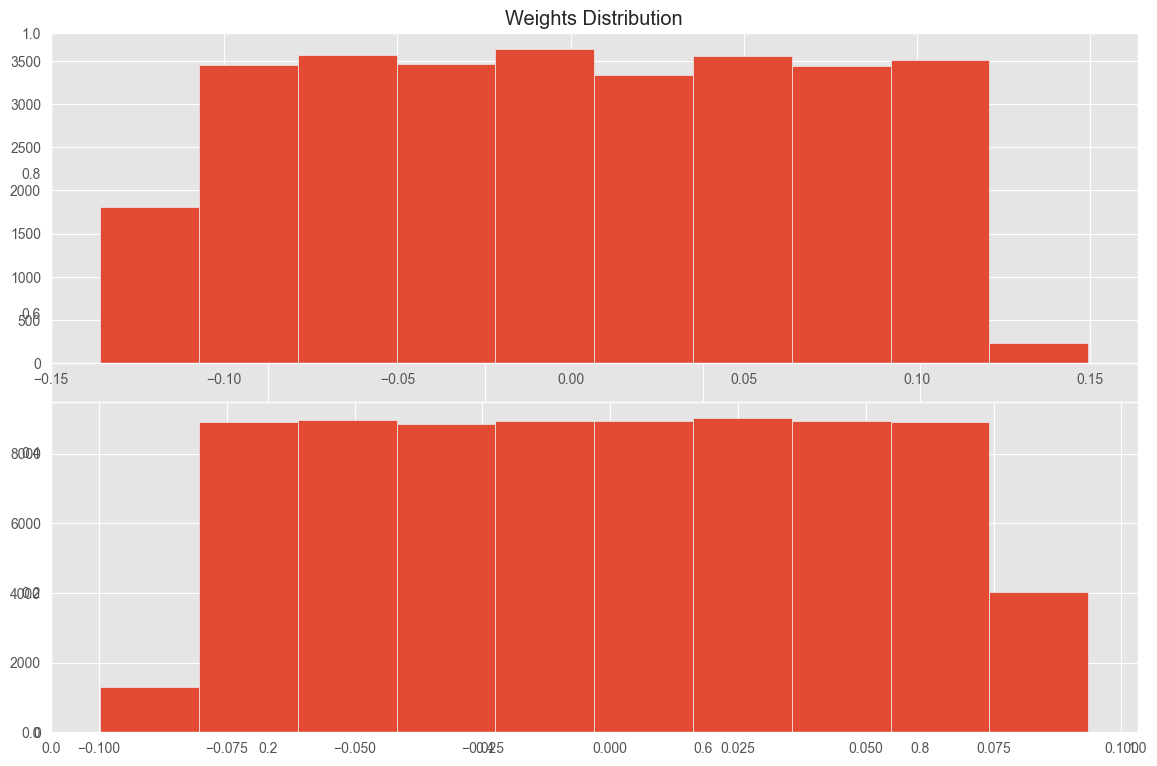

In [44]:
plt.figure(figsize=(12, 8))
plt.title('Weights Distribution')
plt.subplot(2, 1, 1)
plt.hist(mlp_base_ft.coefs_[0].flatten())
plt.subplot(2, 1, 2)
plt.hist(mlp_base_bt.coefs_[0].flatten())
plt.tight_layout()

In [216]:
print('Fasttext test set MSE: ', np.round(mean_squared_error(y_test_ft, mlp_base_ft.predict(X_test_ft)), 4))
print('BERT test set MSE: ', np.round(mean_squared_error(y_test_bt, mlp_base_bt.predict(X_test_bt)), 4))

Fasttext test set MSE:  0.0661
BERT test set MSE:  0.0655


In [48]:
def plot_compare_models(models, labels, title):
    plt.figure(figsize=(7, 7))
    for model, label in zip(models, labels):
        plt.plot(np.arange(model.n_iter_), model.loss_curve_, label=label)
    plt.legend()
    plt.title(title)

## Eksperymenty - fasttext
### Testowanie różnych ilości warstw 

In [217]:
size_ft_models = []

hidden_layer_sizes_tested = [[100], [100, 100], [300, 300, 200, 100]]

for hidden_layer_sizes in hidden_layer_sizes_tested:
    print(f'Train model with sizes: {hidden_layer_sizes}')
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                       solver='sgd', alpha=0.0, learning_rate='constant', verbose=True)

    mlp.fit(X_train_ft, y_train_ft)
    size_ft_models.append(mlp)

Model dla większej ilości warstw zaczyna z coraz mniejszym błędem i szybciej osiąga zbieżność. Różnica między modelem o warstwach [100, 100] i większym nie są aż tak duże, więc dalsze zwiększanie nie polepszyło by prawdopodobnie wyników. 

Fasttext test set MSE:  0.0657
Fasttext test set MSE:  0.0658
Fasttext test set MSE:  0.0657


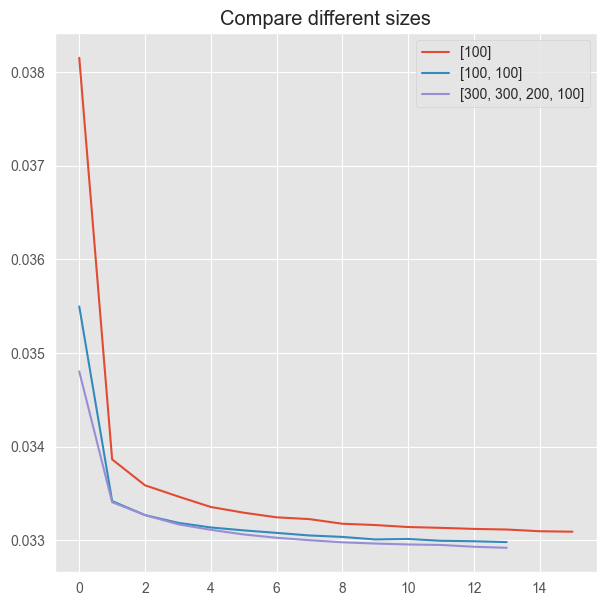

In [ ]:
plot_compare_models(size_ft_models, hidden_layer_sizes_tested, 'Compare different sizes')
for model in size_ft_models:
    print('Fasttext test set MSE: ', np.round(mean_squared_error(y_test_ft, model.predict(X_test_ft)), 4))

### Testowanie różnych współczynników uczenia

In [ ]:
lr_ft_models = []

learning_rates = [0.00001, 0.0001, 0.001]

for learning_rate in learning_rates:
    print(f'Train model with lr: {learning_rate}')
    mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', 
                       learning_rate_init=learning_rate, verbose=True)

    mlp.fit(X_train_ft, y_train_ft)
    lr_ft_models.append(mlp)

*Zbyt mały współczynnik uczenia* - model zaczyna z większym błędem i wymaga o wiele więcej iteracji, aby zbiec do 'plateu'
*Zbyt duży współczynnik uczenia* - już dla $lr=0.01$ zmiany wag były zbyt duże i skutkowały pojawieniem się wartości NaN

Fasttext test set MSE:  0.0692
Fasttext test set MSE:  0.0662
Fasttext test set MSE:  0.0658


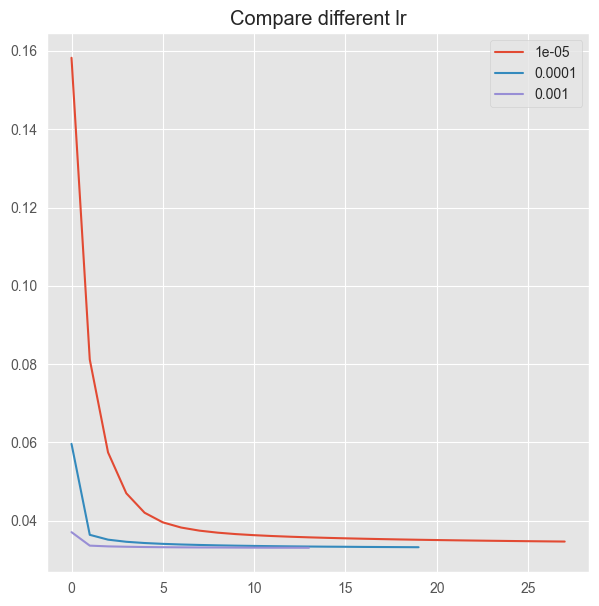

In [233]:
plot_compare_models(lr_ft_models, learning_rates, 'Compare different lr')
for model in lr_ft_models:
    print('Fasttext test set MSE: ', np.round(mean_squared_error(y_test_ft, model.predict(X_test_ft)), 4))

### Eksperymenty - BERT
#### Testowanie różnych ilości warstw

In [ ]:
size_bt_models = []

hidden_layer_sizes_tested = [[100], [100, 100], [300, 300, 200, 100]]

for hidden_layer_sizes in hidden_layer_sizes_tested:
    print(f'Train model with sizes: {hidden_layer_sizes}')
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                       solver='sgd', alpha=0.0, learning_rate='constant', verbose=True)

    mlp.fit(X_train_bt, y_train_bt)
    size_bt_models.append(mlp)

W przypadku embeddingów z BERT'a zdaje się, że najmnniejszy model trenował się najlepiej, bo jego krzywa uczenia się jest poniżej tych dla większych modeli. 

BERT test set MSE:  0.0655
BERT test set MSE:  0.0655
BERT test set MSE:  0.0655


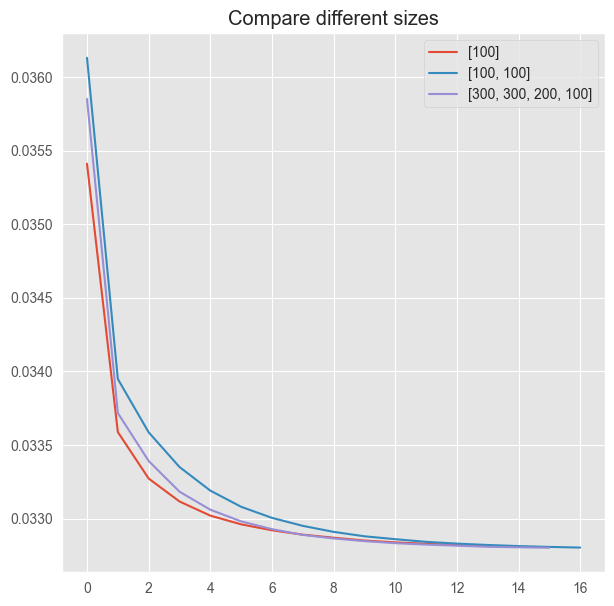

In [236]:
plot_compare_models(size_bt_models, hidden_layer_sizes_tested, 'Compare different sizes')
for model in size_bt_models:
    print('BERT test set MSE: ', np.round(mean_squared_error(y_test_bt, model.predict(X_test_bt)), 4))

### Testowanie różnych współczynników uczenia

In [ ]:
lr_bt_models = []

learning_rates = [0.00001, 0.0001, 0.001]

for learning_rate in learning_rates:
    print(f'Train model with lr: {learning_rate}')
    mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', 
                       learning_rate_init=learning_rate, verbose=True)

    mlp.fit(X_train_bt, y_train_bt)
    lr_bt_models.append(mlp)

Sytuacja bardzo podobna jak dla modelu z *fasttext*, tu również dla zbyt dużego współczynnika występowały wartości NaN. 

BERT test set MSE:  0.0707
BERT test set MSE:  0.0667
BERT test set MSE:  0.0656


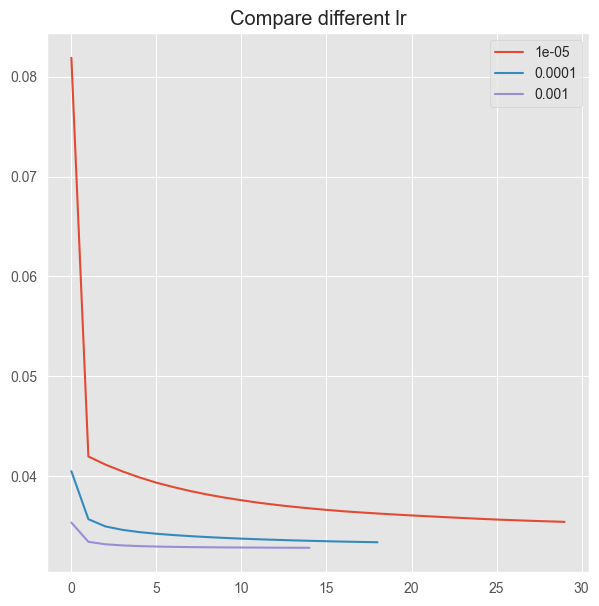

In [240]:
plot_compare_models(lr_bt_models, learning_rates, 'Compare different lr')
for model in lr_bt_models:
    print('BERT test set MSE: ', np.round(mean_squared_error(y_test_bt, model.predict(X_test_bt)), 4))

#### Dodatkowy eksperyment - różnie rozmiary batch'y
Przetestowane zostały wielkości mniejsze, niż użyte w poprzednich testach (wg. dokumentacji dla klasy MLPRegressor rozmiarem domyślnym jest 200) i jedna większa. 

In [ ]:
bs_ft_models = []

batch_sizes = [32, 64, 128, 256]

for batch_size in batch_sizes:
    print(f'Train model with batch size: {batch_size}')
    mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant', 
                       verbose=True, batch_size=batch_size)

    mlp.fit(X_train_ft, y_train_ft)
    bs_ft_models.append(mlp)

Dla wielkości 32 i 64 w porównaniu z wielkościami 128 i 256 uczenie wymagało więcej epok, aby osiągnąć 'plateu', jednak końcowo błąd przy użyciu tych wielkości był mniejszy.

Fasttext test set MSE:  0.0659
Fasttext test set MSE:  0.0657
Fasttext test set MSE:  0.0663
Fasttext test set MSE:  0.0667


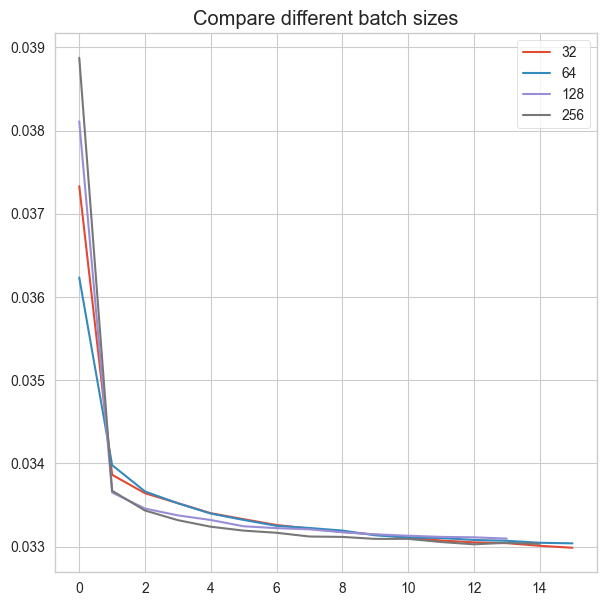

In [49]:
plot_compare_models(bs_ft_models, batch_sizes, 'Compare different batch sizes')
for model in bs_ft_models:
    print('Fasttext test set MSE: ', np.round(mean_squared_error(y_test_ft, model.predict(X_test_ft)), 4))

### Najlepszy model - test


In [43]:
unfunny_joke = '''
Why did the scarecrow win an award?
Because he was outstanding in his field.
'''

funny_joke = '''
What is the difference between a teacher and a train? 
One says, “Spit out your gum,” and the other says, “Choo choo choo!”
'''

In [44]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-cased')
funny_embedding = model.encode([funny_joke])
unfunny_embedding = model.encode([unfunny_joke])

No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.


Model raczej nie działa za dobrze bo dla zabawnego żartu dał gorszy wynik niż dla niezabawnego :(

In [45]:
mlp_base_bt.predict(funny_embedding)

array([-0.2408658], dtype=float32)

In [46]:
mlp_base_bt.predict(unfunny_embedding)

array([-0.11757392], dtype=float32)